In [1]:
import os

import gym
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import clear_output, display

from stable_baselines.a2c.utils import ortho_init
from stable_baselines.common.policies import MlpPolicy, ActorCriticPolicy # register_policy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy

ModuleNotFoundError: No module named 'pybullet_envs'

In [2]:
log_dir = "tmp/gym/humanoid_pybullet/log/"
archive_dir = "tmp/gym/humanoid_pybullet/archive/"

#### Step 1: Set up wrapper, multiprocessing, and callback
- Wrapper tutorial: https://hub.packtpub.com/openai-gym-environments-wrappers-and-monitors-tutorial/

In [3]:
# Set up Wrapper
from gym import RewardWrapper

class ModifyReward(RewardWrapper):
    def __init__(self, env):
        super(ModifyReward, self).__init__(env)

    def reward(self, reward):
        return reward
    
##########################################################################################
# Set up multiprocessing
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses 
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    
    def _init():
        env = ModifyReward(gym.make(env_id))
        log_sub_dir = log_dir + '/env_{}'.format(str(rank))
        os.makedirs(log_sub_dir, exist_ok=True)
        env = Monitor(env, log_sub_dir, allow_early_resets=True)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

##########################################################################################
# Set up callback
best_mean_reward, n_steps = -np.inf, 0

def extract_xy(log_dir):
    """
    extract the # time steps and avg reward
    :param x: (int) # of time steps
    :param y: (float) average rewards
    """
    num_folder = 0
    x = 0
    y = []
    for folder in os.listdir(log_dir):
        if 'env' in folder:
            x_tmp, y_tmp = ts2xy(load_results(log_dir+folder), 'timesteps')
            if len(x_tmp) > 0:
                y.extend(list(y_tmp[-10:]))
                if x_tmp[-1] > x:
                    x = x_tmp[-1]
    y = sum(y)/len(y) if len(y) > 0 else -np.inf 
    return x, y

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 2 calls
    if (n_steps + 1) % 2 == 0:
        # Evaluate policy training performance
        x, y = extract_xy(log_dir)
        if x > 0:
            mean_reward = y
            clear_output(wait=True)
            # use display(f) if you encounter performance issues
            print(x, 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}". \
                  format(best_mean_reward, mean_reward))
            
            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

#### Step 2: Set up environment 

In [4]:
env_id = "HumanoidBulletEnv-v0"
num_cpu = 8  # Number of processes to use
# Create the vectorized environment

# Create log dir

os.makedirs(log_dir, exist_ok=True)

env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)], start_method = 'fork')

#### Step 3: Define the Model

In [5]:
# default policy network: 2 layer 64-neuron network for both value vf and action pi
# policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[dict(vf=[64,64], pi=[64,64])])

# modified policy network: without bottleneck
# policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,256])])
# policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,256,8,256])])

# modified policy network: with bottleneck
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,256,256])])

###############################################################################################################

def learning_rate(frac):
    return 1.0e-4*(np.exp(6*(frac-1)))

model = PPO2(MlpPolicy, env, verbose=0, policy_kwargs=policy_kwargs, 
             noptepochs=15, n_steps=512, learning_rate=learning_rate)

In [6]:
# display network information here
model.get_parameter_list()

[<tf.Variable 'model/pi_fc0/w:0' shape=(44, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc0/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc0/w:0' shape=(44, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc0/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc1/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc1/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc2/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc2/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc2/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/vf_fc2/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc3/w:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'model/pi_fc3/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'model/vf/w:0' shape=(256, 1) dtype=

In [27]:
model.get_parameters()["model/pi_fc2/b:0"]

array([ 0.01837003,  0.01667255,  0.0185922 , -0.00522721, -0.00571536,
        0.00619774,  0.00116917,  0.0148859 ,  0.020814  ,  0.00850734,
        0.01218347,  0.00572681,  0.0285808 ,  0.00740609,  0.00212689,
        0.02065461,  0.02331659,  0.00102989,  0.00200971,  0.01421432,
        0.02607763,  0.00626727, -0.01078121,  0.0276042 ,  0.00783089,
        0.01789778,  0.02356929,  0.02208541,  0.00131319,  0.0129709 ,
        0.0124737 ,  0.02067362,  0.02698545,  0.03120698,  0.00254492,
        0.01474252, -0.00500937, -0.01370451,  0.01728063,  0.01361042,
       -0.00373221, -0.01025863,  0.0086777 , -0.00865908,  0.02341103,
        0.00834012,  0.02015799,  0.03426618, -0.00113818,  0.01222675,
        0.01342892,  0.02806729,  0.01662763,  0.00178044, -0.0026175 ,
        0.01924159,  0.00871076,  0.02650312,  0.00033043,  0.00468089,
        0.01198027, -0.00680539,  0.03257947,  0.0208294 ,  0.02107684,
        0.01943783,  0.01472674,  0.02599429, -0.00845205,  0.00

#### Step 4: Train the agent

In [21]:
# load existing models
# model.load_parameters('PPO2_humanoid', exact_match=False)
model.load_parameters(log_dir+'best_model.pkl', exact_match=True)

In [ ]:
model.learn(total_timesteps=40000000, callback=callback)

# saves the agent as a .pkl file
model.save(log_dir+'latest_model') 

#### Step 5: Plot the results

In [3]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve', instances=1, same_plot=False):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    :instances: (int) the number of instances to average
    """
    x, y = ts2xy(load_results(log_folder+'/env_0'), 'timesteps')

    if instances > 1:
        for i in range(1,instances):
            _, y_tmp = ts2xy(load_results(log_folder+'/env_'+str(i)), 'timesteps')
            if len(y) > len(y_tmp):
                y = y[:len(y_tmp)] + y_tmp
            else:
                y = y + y_tmp[:len(y)]
        y = y/instances
    
    y = moving_average(y, window=30) # change window value to change level of smoothness
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    if same_plot is False:
        plt.show()

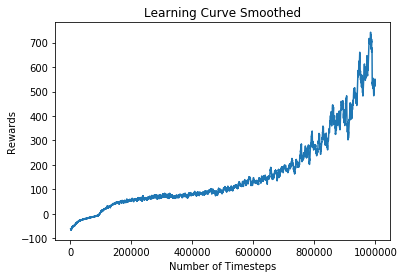

In [12]:
plot_results(log_dir)

#### Step 6: Render the results

In [5]:
# env_v = gym.make('HumanoidBulletEnv-v0', render="True")
obs = env_v.reset()
for i in range(3000):
    # actions, _states = model.predict(obs)
    actions = env_v.action_space.sample()
    obs, rewards, dones, info = env_v.step(actions)

# Extra Results

## model rendering

In [9]:
env_v = gym.make('HumanoidBulletEnv-v0', render="True")
model_v = PPO2.load(archive_dir + 'RL 256-256-256-256/best_model.pkl')
obs = env_v.reset()
for i in range(1000):
    actions, _states = model_v.predict(obs)
    obs, rewards, dones, info = env_v.step(actions)

## Reward progression comparison

Text(0.5, 1.0, 'N/A')

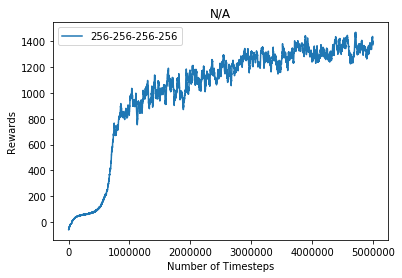

In [6]:
plot_results(archive_dir+'RL 256-256-256-256', instances=8, same_plot=True)
plt.legend(['256-256-256-256'])
plt.title('N/A')